In [9]:
# Parallelization - run on hpc05
from hpc05 import Client
rc = Client()
lview = rc.load_balanced_view()
dview = rc[:]

In [10]:
len(rc)

100

In [11]:
%%px --local
import kwant
import scipy
import numpy as np
from scipy.linalg import block_diag

from types import SimpleNamespace

import Modules.pauli as pauli
import Modules.TB_parameters as Tpar
import Modules.ribbon_params_11_band as rp
import Modules.Ham_MX2_11_band as Ham
import Modules.functions as func

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

In [13]:
%%px --local

# def dispersion_armchair(ky, params, W, bands=100, spin=True, SC=True):
#     params['k_y'] = ky
#     lead = func.MX2_system(W = W, sys_type='lead', spin=spin, SC=SC, plot_sys=False, finalize=False)
#     wrap_lead = kwant.wraparound.wraparound(lead, coordinate_names=('y', 'x', 'z')).finalized()
#     ham = wrap_lead.hamiltonian_submatrix(params=params, sparse=True).tocsc()
#     return scipy.sparse.linalg.eigsh(ham, k=bands, sigma=0.0, which='LM', return_eigenvectors=False)

def dispersion_armchair(ky, W, params, bands=100, SC=True, spin=True):
    """ky momentum, W width of the ribbon. """
    flead = func.MX2_system(W=W, sys_type='lead', spin=spin, SC=SC, plot_sys=False, finalize=True)
    # Cell Hamiltonian and hoppings
    h0 = flead.cell_hamiltonian(params=params, sparse=True).tocsc()
    t0 = flead.inter_cell_hopping(params=params, sparse=True).tocsr()
    # Extend hopping to match the shape of the cell Hamiltonian
    t0 = scipy.sparse.csr_matrix((t0.data, t0.indices, t0.indptr), shape=h0.shape, copy=False).tocsc()
    Hk = h0 + t0*np.exp(-1j*ky) + t0.T.conj()*np.exp(1j*ky)
    return scipy.sparse.linalg.eigsh(Hk, k=bands, sigma=0.0, which='LM', return_eigenvectors=False)

In [14]:
%%px --local
spin = True; SC = True
bands = 200
params = dict(Ex=0, Ey=0, Delta=0.8e-3, mu=1.83)
sqrt = 6e-3
Ex = np.sqrt(sqrt**2 + params['Delta']**2)
params['Ex'] = Ex
widths = [200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500]
keys = [str(W) for W in widths]

In [15]:
mom_bound = np.pi
moms = np.linspace(-0.5*mom_bound, 0.5*mom_bound, 1001)

In [16]:
d_dict = {}
for W, key in zip(widths, keys):
    dview['W'] = W
    data = lview.map_async(lambda ky: dispersion_armchair(ky, W, params, bands=bands, spin=spin, SC=SC),
                           moms)
    data.wait_interactive()
    d_dict[key] = data.get()

1001/1001 tasks finished after 1792 s
done


CompositeError: one or more exceptions from call to method: <lambda>
[25:apply]: MemoryError: 
[35:apply]: MemoryError: 
[43:apply]: MemoryError: 
[33:apply]: MemoryError: 
.... 398 more exceptions ...

In [20]:
import os
import pickle
path = os.path.dirname(os.path.dirname(os.getcwd())) + '/data/11_band/dispersions/'
out_name = 'armchair_dispersions_mu183eV_sqrt6meV_Delta08meV_extended_cell'
# Write everything to a pickle file
with open(path + out_name + '.p', 'wb') as fp:
    pickle.dump(d_dict, fp)
    pickle.dump(moms, fp)
    pickle.dump(widths, fp)
    pickle.dump(keys, fp)
    pickle.dump(params, fp)
    pickle.dump(spin, fp)
    pickle.dump(SC, fp)

(-0.00016, 0.00016)

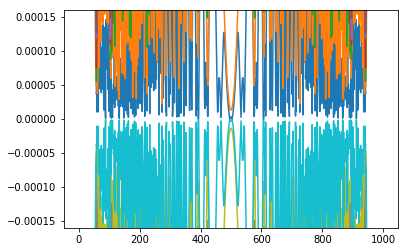

In [26]:
plt.plot(np.sort(np.array(d_dict['500']), axis=-1));
delta = 0.8e-3
plt.ylim(-0.2*delta, 0.2*delta)

In [ ]:
# %%px --local
spin = True; SC = True
bands = 100
params = dict(k_x=0, k_y=0, Ex=0, Ey=0, Delta=0.8e-3, mu=1.83)
sqrt = 6e-3
Ex = np.sqrt(sqrt**2 + params['Delta']**2)
params['Ex'] = Ex
widths = [300, 400, 500, 600, 700, 1000]
keys = [str(W) for W in widths]

In [ ]:
# Period from wraparound is 2*pi, and 2*pi/sqrt(3) for the Bloch Hamiltonian (in ky). Need the same proportionality
# coefficient for both: if we move out of the Fermi surface for ky = a*2*pi
mom_bound = np.pi
moms = np.linspace(-0.5*mom_bound, 0.5*mom_bound, 1001)

In [ ]:
d_dict = {}
for W, key in zip(widths, keys):
    dview['W'] = W
    data = lview.map_async(lambda ky: dispersion_armchair(ky, params, W, bands=bands, spin=spin, SC=SC),
                           moms)
    data.wait_interactive()
    d_dict[key] = data.get()

In [ ]:
d_dict.keys()

In [ ]:
# plt.plot(d_dict['1500'], '.');
# plt.ylim([-0.2*0.8e-3, 0.2*0.8e-3])

In [ ]:
import os
import pickle
path = os.path.dirname(os.path.dirname(os.getcwd())) + '/data/11_band/dispersions/'
out_name = 'armchair_dispersions_mu183eV_sqrt6meV_Delta08meV_better_zoom'
# Write everything to a pickle file
with open(path + out_name + '.p', 'wb') as fp:
    pickle.dump(d_dict, fp)
    pickle.dump(moms, fp)
    pickle.dump(widths, fp)
    pickle.dump(keys, fp)
    pickle.dump(params, fp)
    pickle.dump(spin, fp)
    pickle.dump(SC, fp)

In [ ]:
disp = [dispersion_armchair(ky, params, 2) for ky in moms]

In [ ]:
plt.plot(disp);

In [ ]:
lead = func.MX2_system(W = 1500, sys_type='lead', spin=spin, SC=SC, plot_sys=True)

In [ ]:
flead = lead.finalized()

In [ ]:
h0 = flead.cell_hamiltonian(params=params, sparse=True).tocsc()
t0 = flead.inter_cell_hopping(params=params, sparse=True).tocsr()
t0 = scipy.sparse.csr_matrix((t0.data, t0.indices, t0.indptr), shape=h0.shape, copy=False).tocsc()

In [ ]:
t0 = flead.inter_cell_hopping(params=params, sparse=True).tocsr()

In [ ]:
t0

In [ ]:
t0 = scipy.sparse.csr_matrix((t0.data, t0.indices, t0.indptr), shape=h0.shape, copy=False).tocsc()

In [ ]:
t0

In [ ]:
h0

In [ ]:
h0.shape

In [ ]:
t0

In [ ]:
a = h0*np.exp(1j*2)

In [ ]:
h0.data.nbytes

In [ ]:
123221632/1000

In [ ]:
lead.finalized().cell_hamiltonian

In [ ]:
h0 = lead.cell_hamiltonian(params=params, )

In [ ]:
wrap_lead = kwant.wraparound.wraparound(lead, coordinate_names=('y', 'x', 'z')).finalized()
ham = wrap_lead.hamiltonian_submatrix(params=params, sparse=True).tocsc()

In [ ]:
ham